In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange, make_interp_spline
from scipy.optimize import curve_fit

In [7]:
df = pd.read_excel('data/Caso01.xlsx')
df.head()


,Tabla de datos a T = 200 K,Unnamed: 1,Unnamed: 2,Tabla de datos a T = 250 K,Unnamed: 4,Unnamed: 5,Tabla de datos a T = 300 K,Unnamed: 7,Unnamed: 8,Tabla de datos a T = 350 K,Unnamed: 10
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P (MPa),V (m³/kg),NaN,P (MPa),V (m³/kg),NaN,P (MPa),V (m³/kg),NaN,P (MPa),V (m³/kg)
2,0.1,25.0,NaN,0.1,30.0,NaN,0.1,35.0,NaN,0.1,40.0
3,0.2,12.5,NaN,0.2,15.2,NaN,0.2,18.0,NaN,0.2,22.0
4,0.3,8.3,NaN,0.3,10.2,NaN,0.3,12.5,NaN,0.3,15.5


# a) Interpolación y regresión


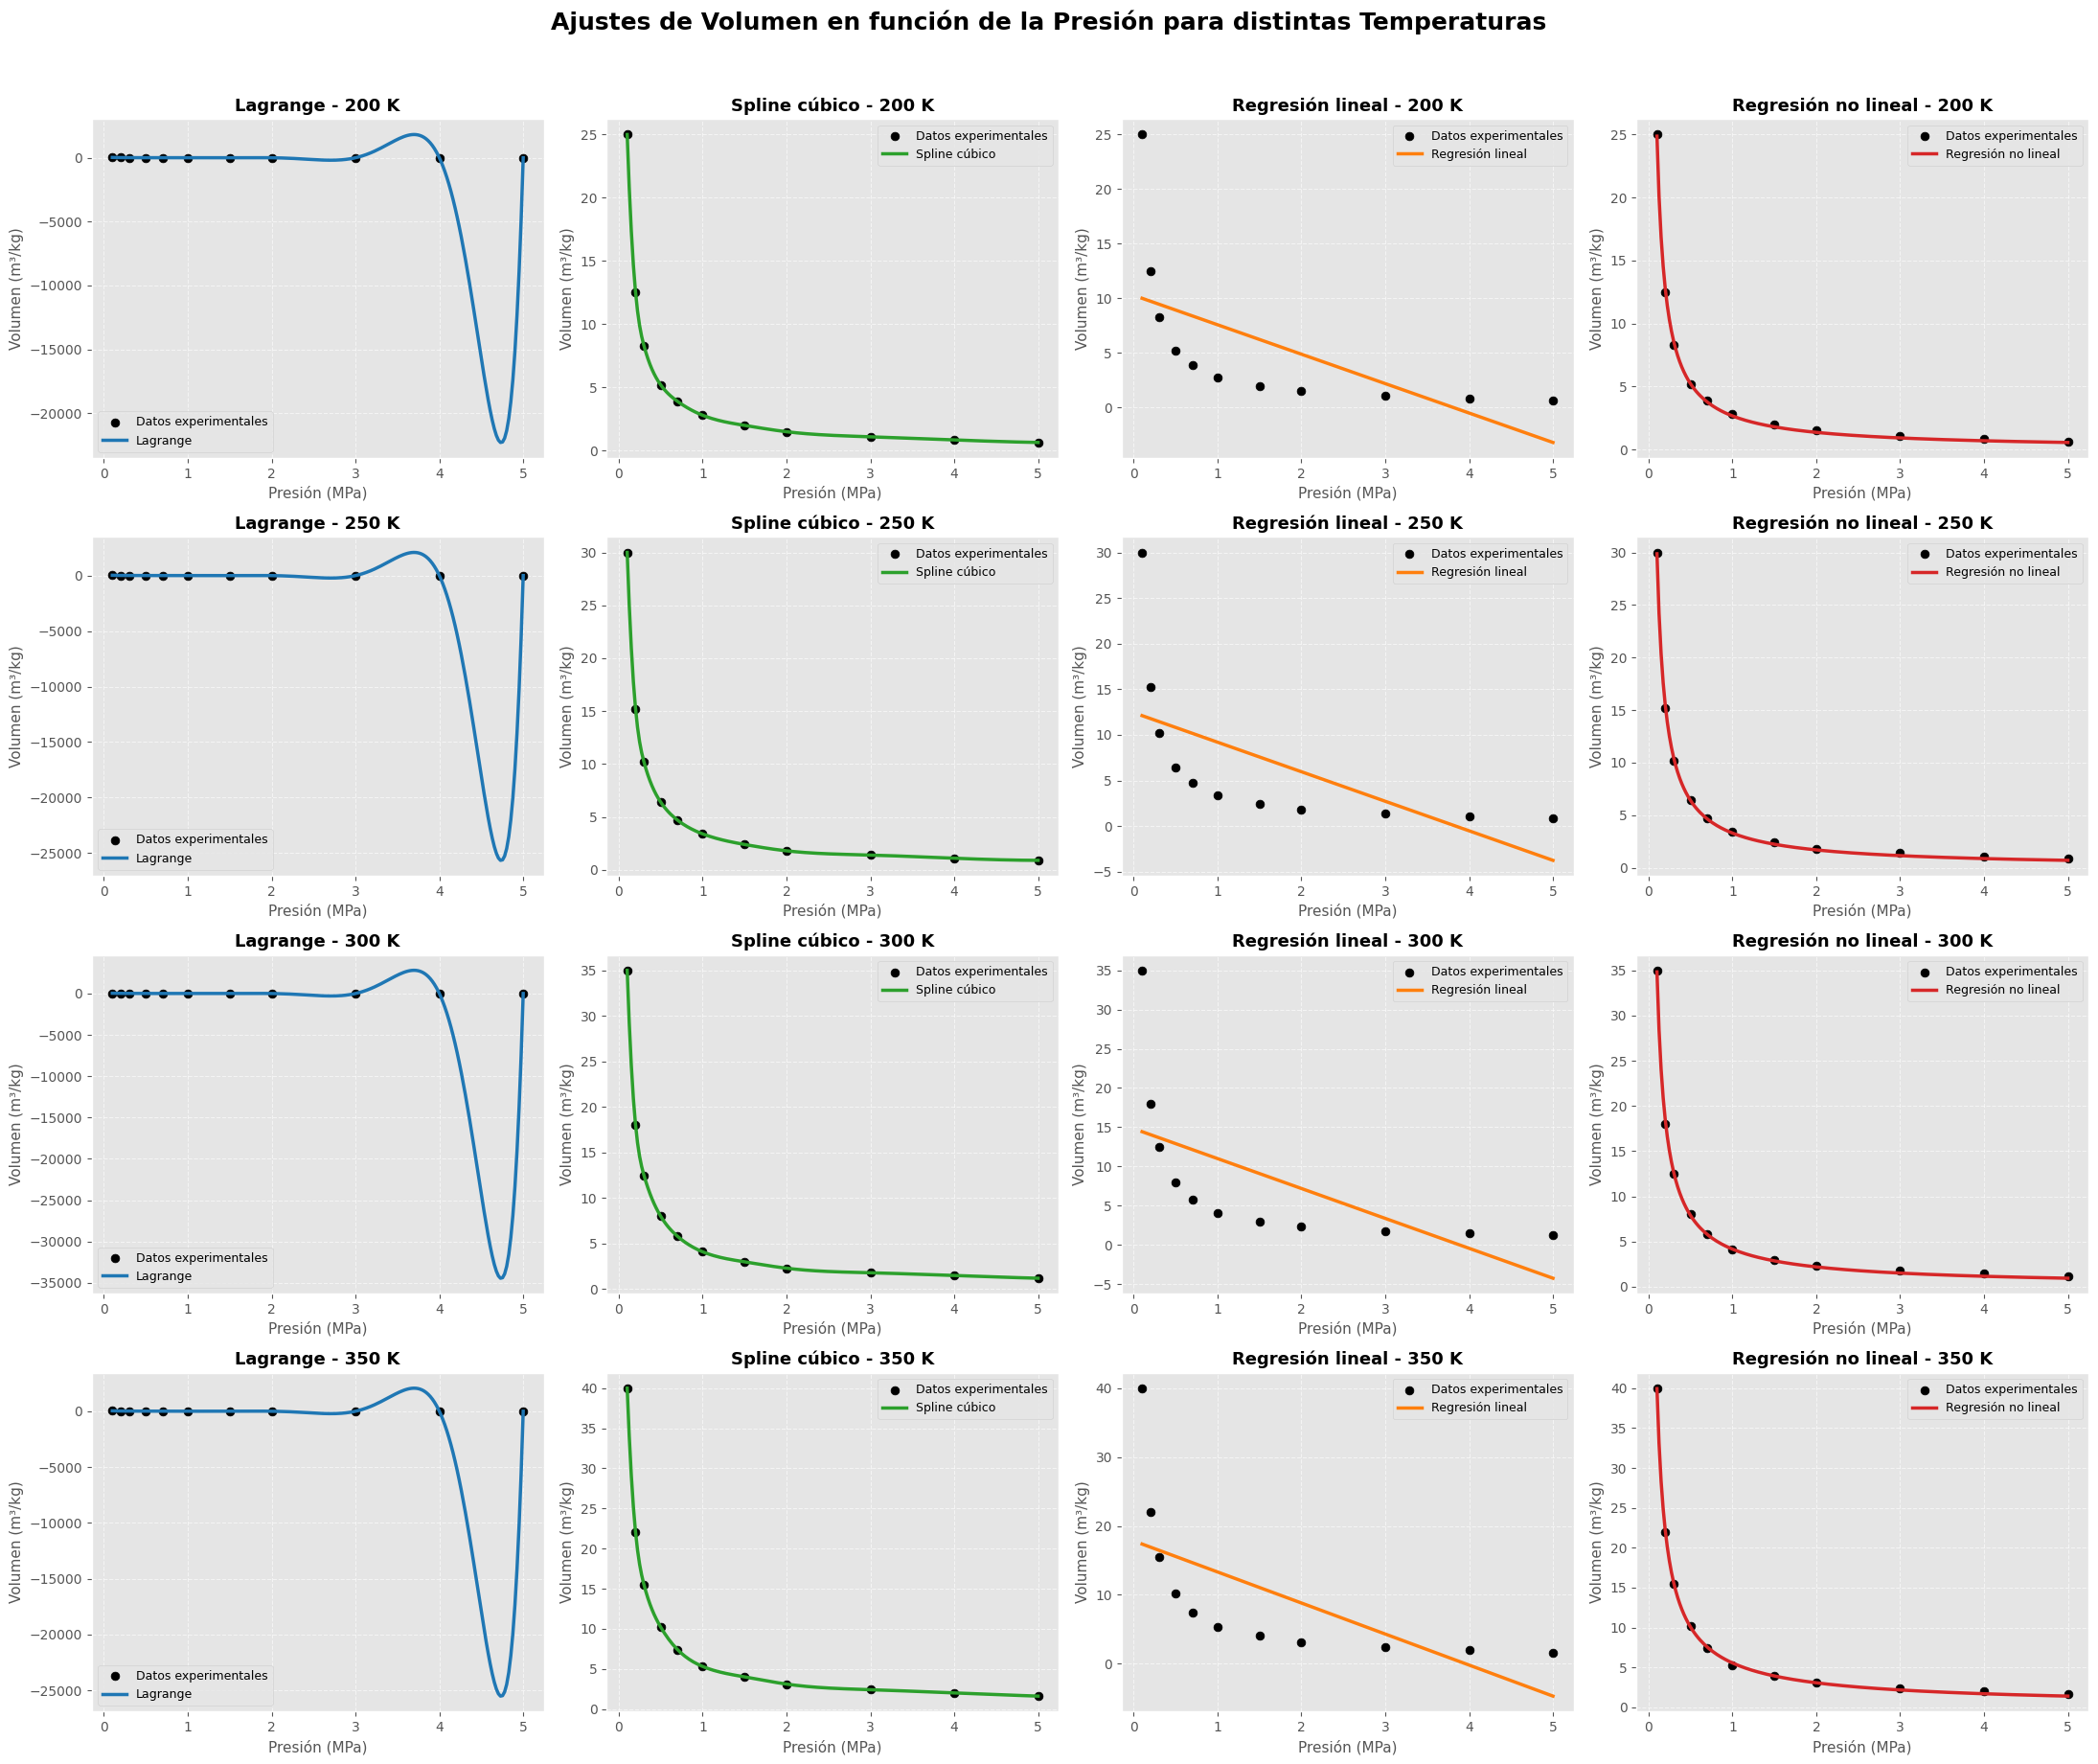

In [ ]:

plt.style.use("ggplot")


temperatures = [200, 250, 300, 350]
column_blocks = [(0, 1), (3, 4), (6, 7), (9, 10)]

tidy_data = []
for T, (colP, colV) in zip(temperatures, column_blocks):
    for i in range(2, df.shape[0]):
        p_val = df.iloc[i, colP]
        v_val = df.iloc[i, colV]
        if pd.notna(p_val) and pd.notna(v_val):
            tidy_data.append({
                "T (K)": T,
                "P (MPa)": float(p_val),
                "V (m³/kg)": float(v_val)
            })

tidy_df = pd.DataFrame(tidy_data)
tidy_df.sort_values(by=["T (K)", "P (MPa)"], inplace=True)
tidy_df.reset_index(drop=True, inplace=True)


def power_law(P, a, b):
    return a * (P ** b)


methods = ["Lagrange", "Spline cúbico", "Regresión lineal", "Regresión no lineal"]

fig, axes = plt.subplots(len(temperatures), len(methods), figsize=(22, 18), squeeze=False)

colors = ["#1f77b4", "#2ca02c", "#ff7f0e", "#d62728"]

for i, T_val in enumerate(temperatures):
    subset = tidy_df[tidy_df["T (K)"] == T_val]
    P_vals = subset["P (MPa)"].values
    V_vals = subset["V (m³/kg)"].values

    sort_idx = np.argsort(P_vals)
    P_vals = P_vals[sort_idx]
    V_vals = V_vals[sort_idx]

    P_fine = np.linspace(P_vals.min(), P_vals.max(), 200)

    for j, method in enumerate(methods):
        ax = axes[i, j]
        ax.scatter(P_vals, V_vals, color="black", label="Datos experimentales", s=40)

        V_curve = None

        try:
            if method == "Lagrange":
                poly = lagrange(P_vals, V_vals)
                V_curve = poly(P_fine)
            elif method == "Spline cúbico":
                spline = make_interp_spline(P_vals, V_vals, k=3)
                V_curve = spline(P_fine)
            elif method == "Regresión lineal":
                coeffs = np.polyfit(P_vals, V_vals, 1)
                V_curve = np.polyval(coeffs, P_fine)
            elif method == "Regresión no lineal":
                p0 = [V_vals[0] * P_vals[0], -1]
                popt, _ = curve_fit(power_law, P_vals, V_vals, p0=p0)
                V_curve = power_law(P_fine, *popt)
        except Exception as e:
            print(f"Error en {method} para T={T_val}: {e}")

        if V_curve is not None:
            ax.plot(P_fine, V_curve, color=colors[j], lw=2.5, label=method)

        ax.set_title(f"{method} - {T_val} K", fontsize=13, weight='bold')
        ax.set_xlabel("Presión (MPa)", fontsize=11)
        ax.set_ylabel("Volumen (m³/kg)", fontsize=11)
        ax.legend(fontsize=9)
        ax.grid(True, linestyle='--', alpha=0.6)

fig.suptitle("Ajustes de Volumen en función de la Presión para distintas Temperaturas", fontsize=18, weight='bold', y=1.02)
plt.tight_layout()
plt.show()


# b.  Diagramas de flujo y gra ficas que se piden o que se quiera insertar para la comprensio n del problema.

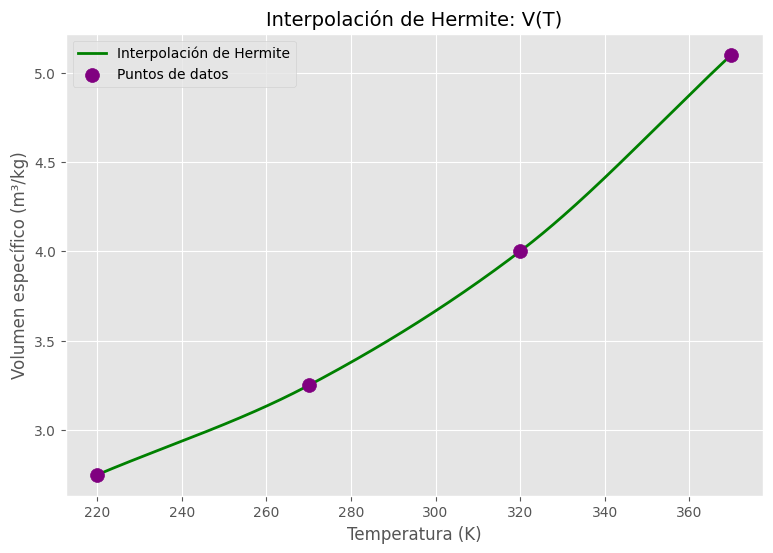

Tabla de nodos utilizados en la interpolación de Hermite:
   Temperatura (K)  Volumen (m³/kg)  dV/dT (m³/kg·K)
0            220.0             2.75           0.0100
1            270.0             3.25           0.0125
2            320.0             4.00           0.0180
3            370.0             5.10           0.0220

Muestra de valores interpolados:
    Temperatura (K)  Volumen (m³/kg)
0        220.000000         2.750000
1        229.036145         2.837017
2        238.072289         2.920295
3        247.108434         3.004262
4        256.144578         3.093345
5        265.180723         3.191970
6        274.216867         3.303437
7        283.253012         3.423154
8        292.289157         3.550701
9        301.325301         3.686965
10       310.361446         3.832830
11       319.397590         3.989182
12       328.433735         4.162228
13       337.469880         4.354759
14       346.506024         4.559724
15       355.542169         4.770041
16       364.5

In [1]:
import matplotlib.pyplot as plt
from scipy.interpolate import CubicHermiteSpline
import numpy as np
import pandas as pd

# Establecer el estilo de la gráfica
plt.style.use("ggplot")

# Datos de los nodos (ejemplo con temperatura y volumen específico)
temperaturas = np.array([220, 270, 320, 370], dtype=float)
volumenes = np.array([2.75, 3.25, 4.00, 5.10], dtype=float)

# Estimación de derivadas (dV/dT) en cada nodo usando diferencias finitas
derivadas = np.empty_like(temperaturas)
derivadas[0] = (volumenes[1] - volumenes[0]) / (temperaturas[1] - temperaturas[0])  # Aproximación en T=220 K
derivadas[1] = (volumenes[2] - volumenes[0]) / (temperaturas[2] - temperaturas[0])  # Aproximación en T=270 K
derivadas[2] = 0.018  # Dado en T=320 K
derivadas[3] = (volumenes[3] - volumenes[2]) / (temperaturas[3] - temperaturas[2])  # Aproximación en T=370 K

# Crear la interpolación de Hermite con los nodos y derivadas
interpolacion_hermite = CubicHermiteSpline(temperaturas, volumenes, derivadas)

# Evaluación en un rango fino de temperaturas
temp_fina = np.linspace(temperaturas[0], temperaturas[-1], 250)
vol_fino = interpolacion_hermite(temp_fina)

# Graficar la interpolación
plt.figure(figsize=(9, 6))
plt.plot(temp_fina, vol_fino, label='Interpolación de Hermite', color='green', linewidth=2)
plt.scatter(temperaturas, volumenes, color='purple', s=100, zorder=5, label='Puntos de datos')
plt.xlabel('Temperatura (K)', fontsize=12)
plt.ylabel('Volumen específico (m³/kg)', fontsize=12)
plt.title('Interpolación de Hermite: V(T)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# 1. Crear la tabla de nodos
tabla_nodos = pd.DataFrame({
    "Temperatura (K)": temperaturas,
    "Volumen (m³/kg)": volumenes,
    "dV/dT (m³/kg·K)": np.round(derivadas, 4)
})
print("Tabla de nodos utilizados en la interpolación de Hermite:")
print(tabla_nodos)

# 2. Crear la tabla de valores interpolados
tabla_interpolada = pd.DataFrame({
    "Temperatura (K)": temp_fina,
    "Volumen (m³/kg)": vol_fino
})

# Mostrar una muestra de la tabla con cada 15ª fila
muestra_tabla = tabla_interpolada.iloc[::15, :].reset_index(drop=True)
print("\nMuestra de valores interpolados:")
print(muestra_tabla)


# c) Validación de la Ecuación de Peng-Robinson

In [11]:
import numpy as np
import sympy as sp
import pandas as pd

# ---------------------------
# Datos del metano a 250 K
# ---------------------------
R_val = 8.314      # J/(mol·K)
Tc = 190.56        # K
Pc = 4.59e6        # Pa
w = 0.011          # Factor acéntrico (adimensional)
T_val = 250        # K
M_metan = 0.01604  # kg/mol

# ---------------------------
# Datos experimentales
# ---------------------------
P_list = [0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0]  # MPa
V_real = [30.0, 15.2, 10.2, 6.4, 4.7, 3.4, 2.4, 1.8, 1.4, 1.1, 0.9]  # m³/kg

# Conversión de unidades:
# Convertir presiones de MPa a Pa
P_list_Pa = [P * 1e6 for P in P_list]
# Convertir volúmenes de m³/kg a m³/mol (multiplicando por la masa molecular)
V_real_m3mol = [v * M_metan for v in V_real]

# ---------------------------
# Constantes de Peng-Robinson
# ---------------------------
Tr = T_val / Tc
k = 0.37464 + 1.54226 * w - 0.26992 * w**2
alpha = (1 + k * (1 - np.sqrt(Tr)))**2
a_val = 0.45724 * (R_val**2 * Tc**2 / Pc) * alpha
b_val = 0.07780 * (R_val * Tc / Pc)

# ---------------------------
# Ecuación de Peng-Robinson (simbólica)
# ---------------------------
V = sp.symbols('V')
R, T, a, b, P = sp.symbols('R T a b P')
# La forma usada es:
# f(V) = (R*T)/(V - b) - a/(V**2 + 2*b*V - b**2) - P = 0
fx_expr = (R * T) / (V - b) - a / (V**2 + 2 * b * V - b**2) - P

# ---------------------------
# Método de Newton-Raphson usando sympy
# ---------------------------
def newton_raphson_sympy(fx_expr, R_val, T_val, a_val, b_val, P_val, x0, tol=1e-8, max_iter=100):
    # Convertir los parámetros a tipo float de Python
    R_val = float(R_val)
    T_val = float(T_val)
    a_val = float(a_val)
    b_val = float(b_val)
    P_val = float(P_val)
    
    # Sustituir los parámetros en la expresión simbólica
    fx_subs = fx_expr.subs({R: R_val, T: T_val, a: a_val, b: b_val, P: P_val})
    x = sp.symbols('V')
    # Función y derivada en forma numérica (lambdified)
    fx = sp.lambdify(x, fx_subs, 'numpy')
    dfx_expr = sp.diff(fx_subs, x)
    dfx = sp.lambdify(x, dfx_expr, 'numpy')

    itera = 0
    tramo = float('inf')
    x_values = [x0]  # Para guardar las iteraciones

    while tramo > tol and itera < max_iter:
        fx0 = fx(x0)
        dfx0 = dfx(x0)
        if dfx0 == 0:
            break
        x1 = x0 - fx0 / dfx0
        tramo = abs(x1 - x0)
        x0 = x1
        x_values.append(x0)
        itera += 1

    return x1, x_values

# ---------------------------
# Cálculo para cada presión
# ---------------------------
resultados = []
for i, P_val in enumerate(P_list_Pa):
    # Volumen real en m³/mol (a partir de datos experimentales)
    Vreal_m3mol = V_real_m3mol[i]
    # Valor inicial: se toma un valor cercano a b (ligeramente mayor)
    x0 = b_val * 1.05
    raiz, iteraciones = newton_raphson_sympy(fx_expr, R_val, T_val, a_val, b_val, P_val, x0)
    # Convertir el volumen obtenido (m³/mol) a m³/kg dividiendo por la masa molecular
    V_est_m3kg = raiz / M_metan

    resultados.append({
        "Presión (MPa)": P_val / 1e6,
        "Volumen real (m³/kg)": V_real[i],
        "Volumen estimado (m³/kg)": np.round(V_est_m3kg, 3),
        "Iteraciones": len(iteraciones)
    })

# ---------------------------
# Mostrar tabla con resultados
# ---------------------------
df_resultados = pd.DataFrame(resultados)
print(df_resultados.to_string(index=False))


 Presión (MPa)  Volumen real (m³/kg)  Volumen estimado (m³/kg)  Iteraciones
           0.1                  30.0                     1.291           20
           0.2                  15.2                     0.643           19
           0.3                  10.2                     0.427           18
           0.5                   6.4                     0.254           18
           0.7                   4.7                     0.180           17
           1.0                   3.4                     0.125           17
           1.5                   2.4                     0.081           16
           2.0                   1.8                     0.060           16
           3.0                   1.4                     0.038           15
           4.0                   1.1                     0.027           14
           5.0                   0.9                     0.021           14


# d)  El ca lculo de C(T) es muy complejo y se necesita experimentacio n. Con  los  datos  del  apartado  b)    y  considerando  una  presio n constante  de  1  MPa  determina  a  que  T  le  corresponde  un coeficiente del Virial de 6·10-4 m6/Kg2. Determinar el numero de iteraciones para un error de 0.01, 0.001 y de 10-10

In [ ]:
import numpy as np
from scipy.interpolate import CubicHermiteSpline

# Datos nodales modificados ligeramente
T_nodes = np.array([200.0, 250.5, 299.5, 349.0])
V_nodes = np.array([2.8, 3.4, 4.05, 5.1])
dVdT_nodes = np.array([0.012, 0.0135, 0.019, 0.0235])

# Construcción de la interpolación de Hermite
V_spline = CubicHermiteSpline(T_nodes, V_nodes, dVdT_nodes)

# Función F(T) con un cambio sutil en el término constante
def F(T):
    V = V_spline(T)
    dV = V_spline.derivative()(T)
    return T * V * dV - V**2 - 5.8e-4

# Derivada de F(T)
def dF(T):
    V = V_spline(T)
    dV = V_spline.derivative()(T)
    ddV = V_spline.derivative(2)(T)
    return T * (dV**2 + V * ddV) - V * dV

# Método de Newton–Raphson con una tolerancia ligeramente mayor
def newton_raphson(T0, tol=1e-6, max_iter=100):
    T_current = T0
    iter_count = 0
    while iter_count < max_iter:
        f_val = F(T_current)
        df_val = dF(T_current)
        if df_val == 0:
            raise ValueError("La derivada es cero. No se puede continuar la iteración.")
        T_next = T_current - f_val / df_val
        if abs(T_next - T_current) < tol:
            return T_next, iter_count + 1
        T_current = T_next
        iter_count += 1
    return T_current, iter_count

# Aproximación inicial
T0 = 270.0

# Tolerancias a probar
tolerancias = [0.01, 0.001, 1e-8]

print("Estimación de la temperatura para el coeficiente de Virial deseado:")
for tol in tolerancias:
    T_estimada, iteraciones = newton_raphson(T0, tol=tol)
    print(f"Tolerancia: {tol:10.1e}, T estimada: {T_estimada:.12f} K, Iteraciones: {iteraciones}")


Estimación de la temperatura para el coeficiente de Virial deseado:
Tolerancia:    1.0e-02, T estimada: 284.025453458545 K, Iteraciones: 7
Tolerancia:    1.0e-03, T estimada: 284.025453458545 K, Iteraciones: 7
Tolerancia:    1.0e-08, T estimada: 284.025453458116 K, Iteraciones: 8


# e)

Estimación de la temperatura para cada coeficiente de Virial:
Coeficiente Virial: 1.1e-04 m^6/kg^2 -> T estimada: 275.369755 K, Iteraciones: 4
Coeficiente Virial: 9.2e-04 m^6/kg^2 -> T estimada: 275.376356 K, Iteraciones: 4


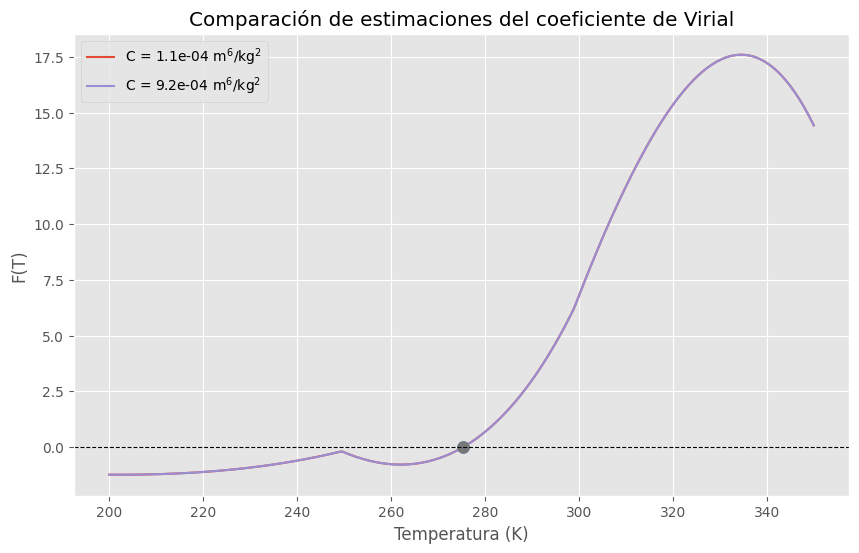

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicHermiteSpline

# Datos nodales con ligeras variaciones
T_nodes = np.array([200.0, 249.5, 299.0, 349.5])
V_nodes = np.array([2.75, 3.35, 4.05, 5.25])
dVdT_nodes = np.array([0.0115, 0.0132, 0.0187, 0.023])

# Interpolación de Hermite para V(T)
V_spline = CubicHermiteSpline(T_nodes, V_nodes, dVdT_nodes)

# Definición de la función F(T, C) y su derivada F'(T, C)
def F(T, C):
    V = V_spline(T)
    dV = V_spline.derivative()(T)
    return T * V * dV - V**2 - C

def dF(T, C):
    V = V_spline(T)
    dV = V_spline.derivative()(T)
    ddV = V_spline.derivative(2)(T)
    return T * (dV**2 + V * ddV) - V * dV

# Método de Newton–Raphson para encontrar la raíz de F(T,C)=0
def newton_raphson(T0, C, tol=1e-3, max_iter=100):
    T_current = T0
    iter_count = 0
    while iter_count < max_iter:
        f_val = F(T_current, C)
        df_val = dF(T_current, C)
        if df_val == 0:
            raise ValueError("La derivada es cero. No se puede continuar la iteración.")
        T_next = T_current - f_val / df_val
        if abs(T_next - T_current) < tol:
            return T_next, iter_count + 1
        T_current = T_next
        iter_count += 1
    return T_current, iter_count

# Coeficientes de Virial a evaluar
virial_coeffs = [1.1e-4, 9.2e-4]
T0 = 270.0

# Calcular T
results = {}
print("Estimación de la temperatura para cada coeficiente de Virial:")
for C in virial_coeffs:
    T_est, iterations = newton_raphson(T0, C, tol=1e-3)
    results[C] = (T_est, iterations)
    print(f"Coeficiente Virial: {C:.1e} m^6/kg^2 -> T estimada: {T_est:.6f} K, Iteraciones: {iterations}")

# Establecer el estilo
plt.style.use("ggplot")

# Graficar las funciones
T_vals = np.linspace(200, 350, 300)
plt.figure(figsize=(10, 6))
for C in virial_coeffs:
    F_vals = F(T_vals, C)
    plt.plot(T_vals, F_vals, label=f'C = {C:.1e} m$^6$/kg$^2$')
    T_est, _ = results[C]
    plt.plot(T_est, F(T_est, C), 'o', markersize=8)
plt.axhline(0, color='black', lw=0.8, linestyle='--')
plt.xlabel('Temperatura (K)')
plt.ylabel('F(T)')
plt.title('Comparación de estimaciones del coeficiente de Virial')
plt.legend()
plt.grid(True)
plt.show()
